<a href="https://colab.research.google.com/github/eisbetterthanpi/pytorch/blob/main/CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Files already downloaded and verified
Files already downloaded and verified


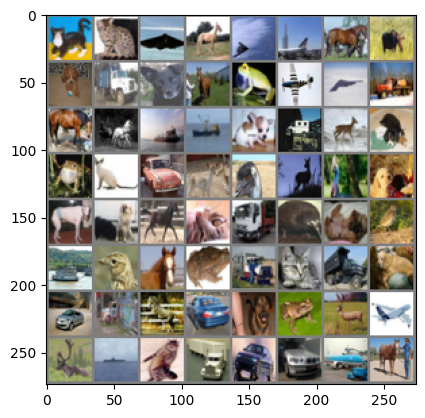

In [6]:
# @title data
import torch
import torch.nn as nn
# import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
# https://github.com/python-engineer/pytorchTutorial/blob/master/14_cnn.py

# dataset has PILImage images of range [0, 1], transform them to Tensors of normalized range [-1, 1]
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
# transform = transforms.Compose(transforms.ToTensor())

# CIFAR10: 60000 32x32 color images in 10 classes, with 6000 images per class
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
batch_size = 64 # 4
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(train_loader) # get some random training images
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images))


In [34]:
# @title model

class ConvLin(nn.Module):
    def __init__(self):
        super(ConvLin, self).__init__()
        plane_list=[64,128,256,512]
        self.conv = nn.Sequential( # nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0),
            nn.Conv2d(3, plane_list[0], 3, 1, 1), nn.BatchNorm2d(plane_list[0]), nn.ReLU(),# nn.MaxPool2d(2, 2),
            nn.Conv2d(plane_list[0], plane_list[1], 3, 1, 1), nn.BatchNorm2d(plane_list[1]), nn.ReLU(), nn.MaxPool2d(2, 2),
            nn.Conv2d(plane_list[1], plane_list[2], 3, 1, 1), nn.BatchNorm2d(plane_list[2]), nn.ReLU(), nn.MaxPool2d(2, 2),
            nn.Conv2d(plane_list[2], plane_list[1], 3, 1, 1), nn.BatchNorm2d(plane_list[1]), nn.ReLU(), nn.MaxPool2d(2, 2),
            nn.Conv2d(plane_list[1], plane_list[0], 3, 1, 1), nn.BatchNorm2d(plane_list[0]), nn.ReLU(), nn.MaxPool2d(2, 2),
        )
        self.linear = nn.Sequential(
            nn.Linear(plane_list[0] * 2 * 2, 256), nn.ReLU(),
            # nn.Linear(plane_list[2] * 8 * 8, 256), nn.ReLU(),
            # nn.Linear(plane_list[2]//16, 256), nn.ReLU(),
            nn.Linear(256, 64), nn.ReLU(),
            nn.Linear(64, 10),
        )

    def forward(self, x):
        x = self.conv(x)
        x = nn.Flatten()(x)
        # print("forward x",x.shape)
        x = self.linear(x)
        return x

class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        plane_list=[64,128,256,512]
        self.conv = nn.Sequential( # nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0),
            nn.Conv2d(3, plane_list[0], 3, 1, 1), nn.BatchNorm2d(plane_list[0]), nn.ReLU(), #nn.MaxPool2d(2, 2),
            nn.Conv2d(plane_list[0], plane_list[1], 3, 1, 1), nn.BatchNorm2d(plane_list[1]), nn.ReLU(), nn.MaxPool2d(2, 2),
            nn.Conv2d(plane_list[1], plane_list[2], 3, 1, 1), nn.BatchNorm2d(plane_list[2]), nn.ReLU(), nn.MaxPool2d(2, 2),
            nn.AdaptiveAvgPool2d((1,1)),
            nn.Conv2d(plane_list[2],64, 1, 1, 0), #nn.BatchNorm2d(64), 
            nn.ReLU(),
            nn.Conv2d(64, 10, 1, 1, 0),
        )

    def forward(self, x):
        x = self.conv(x)
        x = torch.squeeze(x)
        return x

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = ConvLin().to(device)
# model = ConvNet().to(device)
# print(model)

loss_list=[]



In [33]:
X = torch.rand(64, 3, 32, 32, device=device)
logits = model(X)
print(logits.shape)
# print(logits[0])
# print(logits[0].argmax(1))
pred_probab = nn.Softmax(dim=1)(logits)
y_pred = pred_probab.argmax(1)
# print(f"Predicted class: {y_pred}")


forward x torch.Size([64, 256])
forward x torch.Size([64, 10])
torch.Size([64, 10])


In [35]:
# @title train test function

def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (x, y) in enumerate(dataloader):
        sx, sy = x.to(device), y.to(device)
        pred = model(sx)
        loss = loss_fn(pred, sy)
        optimizer.zero_grad() # reset gradients of model parameters, to prevent double-counting
        loss.backward() # Backpropagate gradients
        optimizer.step() # adjust the parameters by the gradients
        if (batch) % (size//(10* len(x))) == 0:
            loss, current = loss.item(), batch * len(x)
            loss_list.append(loss)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            x, y = X.to(device), y.to(device)
            pred = model(x)
            # loss = loss_fn(pred, y)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return correct


In [36]:
import time
start = time.time()
loss_fn = nn.CrossEntropyLoss()

epochs = 10 #5 20

# # optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)
optimizer = torch.optim.SGD(model.parameters(), lr = 1e-1, momentum=0.9)

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_loader, model, loss_fn, optimizer)
    test(test_loader, model, loss_fn)
print("Done!")

end = time.time()
print("time: ",end - start)

torch.save(model.state_dict(), "model.pth")
# model = ConvNet().to(device)
# model.load_state_dict(torch.load("model.pth"))


Epoch 1
-------------------------------
loss: 2.302407  [    0/50000]
loss: 1.929585  [ 4992/50000]
loss: 1.454987  [ 9984/50000]
loss: 1.340527  [14976/50000]
loss: 1.449346  [19968/50000]
loss: 1.388358  [24960/50000]
loss: 1.368952  [29952/50000]
loss: 1.153224  [34944/50000]
loss: 1.059784  [39936/50000]
loss: 1.014527  [44928/50000]
loss: 1.227857  [49920/50000]
Test Error: 
 Accuracy: 59.8%, Avg loss: 1.177585 

Epoch 2
-------------------------------
loss: 0.922786  [    0/50000]
loss: 1.004809  [ 4992/50000]
loss: 1.091128  [ 9984/50000]
loss: 1.284621  [14976/50000]
loss: 1.014368  [19968/50000]
loss: 1.212538  [24960/50000]
loss: 0.670375  [29952/50000]
loss: 0.943115  [34944/50000]
loss: 0.859120  [39936/50000]
loss: 0.715272  [44928/50000]
loss: 0.879412  [49920/50000]
Test Error: 
 Accuracy: 70.7%, Avg loss: 0.853924 

Epoch 3
-------------------------------
loss: 0.714073  [    0/50000]
loss: 0.663618  [ 4992/50000]
loss: 0.954553  [ 9984/50000]
loss: 1.033814  [14976/500

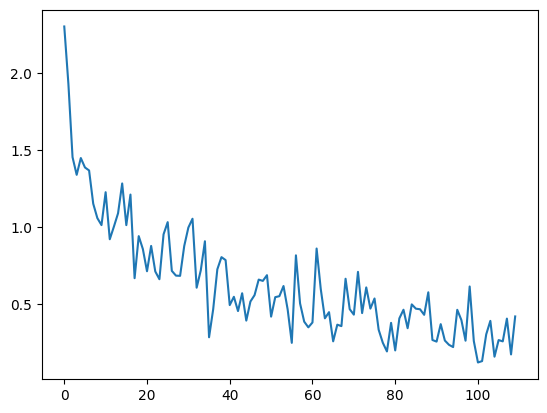

In [37]:
import matplotlib.pyplot as plt
plt.plot(loss_list)
# plt.yscale('log')
plt.show()
